<a href="https://colab.research.google.com/github/M-Dogra/Python/blob/main/Customer_Segmentation_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import plotly.express as px

load dataset from [E-Commmerce Data from UCI](https://archive.ics.uci.edu/dataset/352/online+retail)

In [5]:
df = pd.read_excel('/content/Online Retail.xlsx')

Explore dataset

In [6]:
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [7]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [8]:
df.drop_duplicates(inplace=True)

# We have 135080 null values for CustomerID. Rows in which the CustomerID column is NaN are removed from the DataFrame

df.dropna(subset=['CustomerID'], inplace=True)

In [9]:
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------  

In [10]:
# create a column Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Revenue  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Cou

## Preprocess Data
Create important features for customer behavior analysis, such as Recency, Frequency, and Monetary (RFM).

In [11]:
##calculate RFM metrics

# convert the InvoiceDate column in the DataFrame df to a datetime object, enabling time-based operations for recency.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Recency : Time since last purchase
snapshot_date = df['InvoiceDate'].max()  #Determine the latest transaction date in the dataset (snapshot_date)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, #recency : most recent transaction date (x.max())|| compute how many days ago transaction occurred =(snapshot_date - x.max())
    'InvoiceNo': 'count', #frequency by counting number of transactions
    'Revenue': 'sum' # monetary = total revenue generated by each customer
}).rename(columns={
    'InvoiceDate' : 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
})

'''Rename the resulting columns for better clarity
'InvoiceDate' → 'Recency'
'InvoiceNo' → 'Frequency'
'Revenue' → 'Monetary' '''

"Rename the resulting columns for better clarity\n'InvoiceDate' → 'Recency'\n'InvoiceNo' → 'Frequency'\n'Revenue' → 'Monetary' "

In [12]:
rfm.describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,91.047118,91.858188,1893.531433
std,100.765435,229.223566,8218.696204
min,0.000000,1.000000,-4287.630000
25%,16.000000,17.000000,291.795000
50%,49.000000,41.000000,644.070000
75%,142.000000,99.250000,1608.335000
max,373.000000,7812.000000,279489.020000


#Normalize Data

In [13]:
# standardize RFM metrics (Recency, Frequency, and Monetary) to make them scale-independent, essential for ML algorithms like clustering

#StandardScaler from sklearn.preprocessing standardizes features by removing mean and scaling to unit variance. Z= (X−μ)/σ​
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)
# fit_transform: Computes mean & standard deviation for each column (using fit) and then applies transformation (scales each value)
# rfm_scaled is a NumPy array where each column is standardized.


rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)
# Convert the scaled NumPy array back into a Pandas DataFrame with same index and column names as the original rfm DataFrame

Clustering (e.g., K-Means):

Clustering algorithms are distance-based, so standardization ensures no feature (e.g., Monetary) dominates due to its larger scale.

In [14]:
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.322023,-0.392056,-0.230420
12347.0,-0.893733,0.393293,0.294055
12348.0,-0.169196,-0.265527,-0.011717
12349.0,-0.725005,-0.082279,-0.016547
12350.0,2.163220,-0.326610,-0.189727


K-Means Clustering is an unsupervised learning technique used to group data into 𝑘 distinct clusters based on similarity. It partitions the dataset into groups by minimizing the distance of each data point from the centroid of its assigned cluster.


## K-Means Clustering

Elbow method to find optimal number of clusters

In [15]:
sse = []
#Sum of Squared Errors (SSE) for various values of 𝑘(the number of clusters) to use in Elbow Method for selecting the optimal 𝑘
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  #Creates a K-Means model for 𝑘 clusters with a fixed random state for reproducibility.
  kmeans.fit(rfm_scaled)
  # Fits the K-Means algorithm to the standardized data (rfm_scaled)
  sse.append(kmeans.inertia_)
  # .inertia_ is a built-in attribute of the KMeans class in scikit-learn, specifically associated with trained KMeans models. It measures the Within-Cluster Sum of Squares (WCSS), commonly referred to as inertia, and serves as a metric for cluster quality in K-Means clustering.

In [16]:
sse

[13116.000000000007,
 9484.644683175242,
 5404.176872084279,
 4024.6570336175428,
 2943.25352845654,
 2472.8812225409965,
 2034.6357095465378,
 1704.6193874869177,
 1520.0246048641127,
 1425.2139661062558]

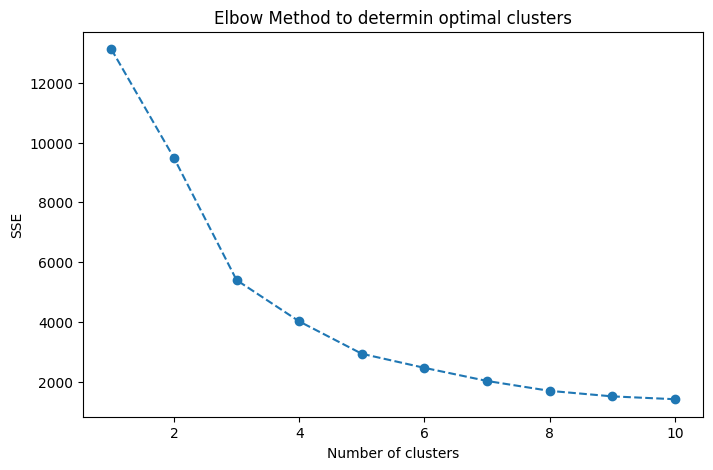

In [17]:
#Plot Elbow curve

plt.figure(figsize=(8,5))
plt.plot(range(1,11),sse, marker='o', linestyle='--')
plt.title('Elbow Method to determin optimal clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [18]:
# apply K-Means with optimal k

optimal_k = 3 #considering 3 clusters based on elbow plot

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
#fit_predict() method fits K-means model to data(rfm_scaled) and then predicts which cluster each data point belongs to
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [19]:
print(rfm)
# print(rfm.groupby('Cluster')['Cluster'].value_counts())
print(rfm.info())

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         325          2      0.00        1
12347.0           1        182   4310.00        0
12348.0          74         31   1797.24        0
12349.0          18         73   1757.55        0
12350.0         309         17    334.40        1
...             ...        ...       ...      ...
18280.0         277         10    180.60        1
18281.0         180          7     80.82        1
18282.0           7         13    176.60        0
18283.0           3        721   2045.53        0
18287.0          42         70   1837.28        0

[4372 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4372 non-null   int64  
 1   Frequency  4372 non-null   int64  
 2   Monetary   4372 non-null   float64
 3   Cluster   

## Apply Principal Component Analysis (PCA) for Dimensionality Reduction

Reduce dimensions to plot clusters effectively in a 2D space.

In [25]:
# perform PCA for visualization

pca = PCA(n_components=2) #reduce data to 2 principal components
rfm_pca = pca.fit_transform(rfm_scaled) # It first fits model to scaled data (rfm_scaled), then it transforms original data into new space defined by top 2 principal components.
rfm['PCA1'] = rfm_pca[:,0] # first column is PCA1
rfm['PCA2'] = rfm_pca[:,1] # second column is PCA2

In [26]:
print(rfm_pca)
print(rfm['PCA1'])
print(rfm['PCA2'])

[[-1.33199603  1.9469661 ]
 [ 0.80350276 -0.62703283]
 [-0.11606598 -0.20677723]
 ...
 [-0.02784014 -0.89909694]
 [ 2.18094429 -0.28057472]
 [ 0.12654753 -0.4617237 ]]
CustomerID
12346.0   -1.331996
12347.0    0.803503
12348.0   -0.116066
12349.0    0.224083
12350.0   -1.199487
             ...   
18280.0   -1.104933
18281.0   -0.737357
18282.0   -0.027840
18283.0    2.180944
18287.0    0.126548
Name: PCA1, Length: 4372, dtype: float64
CustomerID
12346.0    1.946966
12347.0   -0.627033
12348.0   -0.206777
12349.0   -0.679065
12350.0    1.830361
             ...   
18280.0    1.529553
18281.0    0.649234
18282.0   -0.899097
18283.0   -0.280575
18287.0   -0.461724
Name: PCA2, Length: 4372, dtype: float64


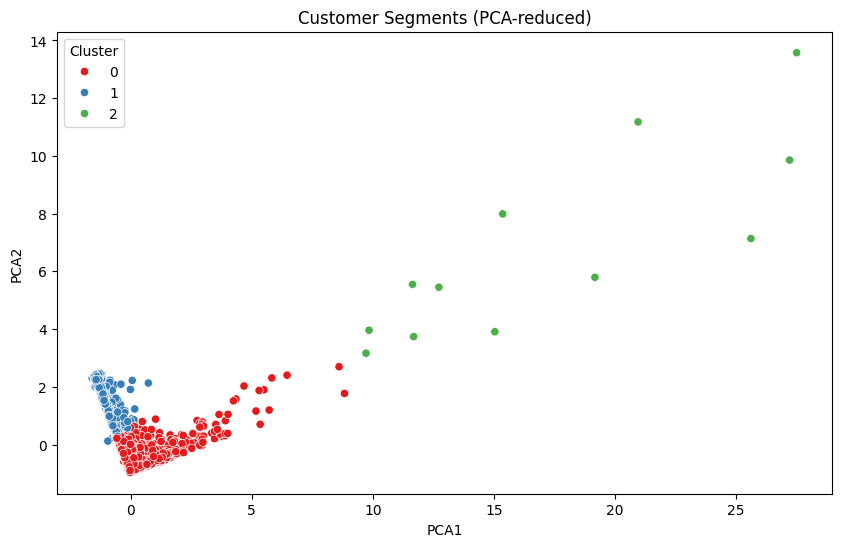

In [32]:
# visualize clusters

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='PCA1', y = 'PCA2', hue='Cluster', palette='Set1')
plt.title('Customer Segments (PCA-reduced)')
plt.show()

The two axes are the principal components derived from the PCA process, representing the directions of maximum variance in the data.

#**Insights from the Clusters:**

**Cluster 0 (Red Points):**
* This is the largest cluster and represents a majority of customers.
* It is mostly concentrated along the lower range of PCA1 and PCA2.
* These customers likely share similar behaviors based on the original features.

**Cluster 1 (Blue Points):**
* This cluster is distinct from Cluster 0 and spread on the lower-left side of the plot.
* Customers in this cluster seem separated from the main group of Cluster 0 in terms of PCA2, which may indicate differences in certain behavioral patterns.

**Cluster 2 (Green Points):**
* This is a smaller and well-isolated cluster on the far-right side of PCA1.
* Customers here are significantly different from the rest in terms of their characteristics (strong outliers or highly specific behaviors).

# **Possible Business Interpretations:**
**Cluster 0:** The largest group, likely represents "average" customers or core audience.

**Cluster 1:** Customers with specific characteristics that set them apart possibly medium or low-value customers based on RFM data (Recency, Frequency, Monetary values).

**Cluster 2:** A niche group of high-value or highly specific behavior customers, like frequent high-spending buyers or VIPs.


## Analyze and Profile Segments

Summarize each cluster based on their RFM metrics to derive actionable insights

In [28]:
# Analyze cluster profiles

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)

print(cluster_summary)

        Recency        Frequency           Monetary           
           mean median      mean  median       mean     median
Cluster                                                       
0         39.10   28.0    103.63    57.0    1947.51     896.00
1        245.76  240.0     27.34    18.0     462.12     294.30
2          4.00    1.5   2813.75  1969.0  118564.64  100669.98


#**Observations:**
* **Cluster 2:** VIP customers who are recent, frequent, and high spenders.
* **Cluster 0:** Moderate-value customers who are relatively frequent and active but have spending potential.
* **Cluster 1:** At-risk customers who are infrequent and low-value spenders with high recency.


## Visualize results

Using Plotly for an interactive customer segmentation plot.

In [29]:
fig = px.scatter(
    rfm, x = 'PCA1', y='PCA2', color='Cluster',
    title='Interactive Customer Segmentation',
    labels={'PCA1': 'PCA Component 1', 'PCA2': 'PCA Component 2'},
    hover_data=['Recency', 'Frequency', 'Monetary'],
)

fig.show()

# **Insights from the Interactive Customer Segmentation Plot:**
1. **Cluster Distribution:**
  * **Cluster 0 (Dark Blue)**: This group is densely packed near the lower-left region (PCA1 ≈ 0 to 5, PCA2 ≈ 0 to 2). These customers have moderate frequency and monetary values with relatively recent interactions.
  * **Cluster 1 (Pink/Purple)**: This cluster is also concentrated in the lower-left region but overlaps slightly with Cluster 0. These customers likely represent less engaged customers with lower monetary value and frequency.
  * **Cluster 2 (Yellow)**: This group is distinct and located far to the right (PCA1 ≈ 10 to 25, PCA2 ≈ 5 to 14). These customers are high-value (VIP) customers, having high monetary value, frequency, and recent activity.
2. **Separation of Clusters:**
  * Cluster 2 (VIP Customers) is clearly separated from the other clusters, indicating a unique segment of high-value customers. These customers have very high RFM metrics.
  * Cluster 0 and Cluster 1 are closer to each other, with some overlap, reflecting similar but slightly differentiated customer behaviors.
3. **Characteristics of Each Cluster:**
  * By hovering over the points, you can observe individual customer attributes (Recency, Frequency, and Monetary scores). For example:
    * Cluster 2 (Yellow): A customer with:
      * Recency = 3 (recent activity),
      * Frequency = 5128 (extremely high frequency),
      * Monetary = 57120.91 (very high spending), is a VIP customer.
    * Cluster 1 (Pink/Purple): Customers in this cluster have high recency but lower frequency and spending, showing disengagement or churn risk.
    * Cluster 0 (Dark Blue): Moderate recency, frequency, and spending levels, reflecting active but not top-tier customers.
4. **Cluster 2 (VIP Customers):**
  * This segment stands out with significantly higher PCA values, which correlate with high RFM scores.
  * This suggests the importance of personalized engagement, loyalty rewards, and premium services for this group to maintain retention.
5. **Cluster Overlap:**The overlap between Cluster 0 and Cluster 1 suggests that there may be some customers who fall between these two segments and could shift to either group depending on their behavior.

---



#**Recommendations Based on Insights:**
1. Cluster 2 (VIP Customers):
  * Focus on retaining this high-value segment through exclusive rewards, personalized offers, and top-notch service.
  * Understand their purchasing behavior to replicate their profile in other clusters.
2. Cluster 0 (Moderate Customers):
  * Encourage these customers to increase their frequency and spending through upselling and cross-selling strategies.
  * Use loyalty programs to incentivize repeat purchases.
3. Cluster 1 (At-Risk Customers):
  * Reactivate these customers with targeted campaigns, such as discounts or special offers.
  * Analyze potential reasons for disengagement (e.g., product dissatisfaction, better offers from competitors) and address them.
